# Dev

In [1]:
# load and plot
import numpy as np
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO
from pathlib import Path
import pandas as pd
from typing import Union
import json
import file_handling

# reload
%matplotlib inline
%reload_ext autoreload
%autoreload 2

output_path = "../results/"

In [2]:
#from hdmf_zarr import NWBZarrIO
from pynwb import NWBHDF5IO, NWBFile, TimeSeries
from pynwb.image import Images, ImageSeries, GrayscaleImage
from pynwb.ophys import (
    CorrectedImageStack,
    Fluorescence,
    DfOverF,
    ImageSegmentation,
    MotionCorrection,
    OnePhotonSeries,
    OpticalChannel,
    RoiResponseSeries,
    TwoPhotonSeries,
)

from datetime import datetime
from uuid import uuid4
from pathlib import Path
from typing import Union
import json
import h5py

import matplotlib.pyplot as plt
import numpy as np
from dateutil.tz import tzlocal
import pandas as pd
import argparse

In [ ]:
# good autoreward session
#multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36
#960c0c20-5d00-4378-bac0-6a585e123f9c

# Make NWB

In [3]:
processed_path  = "../data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36"
file_paths = file_handling.get_multiplane_processed_file_paths(processed_path)

In [10]:
file_paths.keys()

dict_keys(['processing_json', 'params_json', 'registered_metrics_json', 'average_projection_png', 'max_projection_png', 'motion_transform_csv', 'segmentation_output_json', 'roi_traces_h5', 'neuropil_correction_h5', 'neuropil_masks_json', 'neuropil_trace_output_json', 'dff_h5', 'extract_traces_json', 'events_oasis_h5', 'processed_plane_path'])

In [12]:
session_name = "_".join(file_paths["processed_path"].name.split("_")[:4])

dt = "_".join(session_name.split("_")[-2:])
converted_dt = datetime.strptime(dt, "%Y-%m-%d_%H-%M-%S").astimezone(tzlocal())

# 1. set up the NWB file
nwbfile = NWBFile(
    session_description="my first synthetic recording", #TODO
    identifier=str(uuid4()), # TODO
    session_start_time=converted_dt, 
    experimenter=["Baggins, Bilbo"], # TODO
    lab="Bag End Laboratory", # TODO
    institution="Allen Institute for Neural Dynamics",
    experiment_description="I went on an adventure to reclaim vast treasures.", # TODO
    session_id=session_name,
)


In [6]:
metadata = file_handling.load_metadata_json_files(file_paths["processed_path"])

In [25]:
metadata['session']

{'describedBy': 'https://raw.githubusercontent.com/AllenNeuralDynamics/aind-data-schema/main/src/aind_data_schema/core/session.py',
 'schema_version': '0.2.6',
 'protocol_id': [],
 'experimenter_full_name': ['Ahrial Young'],
 'session_start_time': '2024-08-26T14:35:46Z',
 'session_end_time': '2024-08-26T14:51:48Z',
 'session_type': 'TRAINING_0_gratings_autorewards_15min',
 'iacuc_protocol': '2115',
 'rig_id': 'MESO.2',
 'calibrations': [],
 'maintenance': [],
 'subject_id': '739564',
 'animal_weight_prior': None,
 'animal_weight_post': None,
 'weight_unit': 'gram',
 'anaesthesia': None,
 'data_streams': [{'stream_start_time': '2024-08-26T14:35:46Z',
   'stream_end_time': '2024-08-26T14:51:48Z',
   'daq_names': [],
   'camera_names': [],
   'light_sources': [{'device_type': 'Laser',
     'name': 'Laser',
     'wavelength': 920,
     'wavelength_unit': 'nanometer',
     'excitation_power': None,
     'excitation_power_unit': 'milliwatt'},
    {'device_type': 'LightEmittingDiode',
     'n

In [50]:
ophys_md = file_handling.metadata_for_multiplane(file_paths["processed_path"])
ophys_md

File rig.json not found in ../data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36


{'session_start_time': '2024-08-26T14:35:46Z',
 'experimenter': ['Ahrial Young'],
 'session_type': 'TRAINING_0_gratings_autorewards_15min',
 'laser_wavelength': 920,
 'wavelength_unit': 'nanometer',
 'ophys_fovs': {'VISp_0': {'index': 0,
   'imaging_depth': 152,
   'imaging_depth_unit': 'micrometer',
   'targeted_structure': 'VISp',
   'fov_coordinate_ml': '1.5',
   'fov_coordinate_ap': '1.5',
   'fov_coordinate_unit': 'micrometer',
   'fov_reference': 'Bregma',
   'fov_width': 512,
   'fov_height': 512,
   'fov_size_unit': 'pixel',
   'magnification': '16x',
   'fov_scale_factor': '0.78',
   'fov_scale_factor_unit': 'um/pixel',
   'frame_rate': '10.63',
   'frame_rate_unit': 'hertz',
   'coupled_fov_index': 0,
   'power': '45.0',
   'power_unit': 'percent',
   'power_ratio': None,
   'scanfield_z': -320,
   'scanfield_z_unit': 'micrometer',
   'scanimage_roi_index': 0,
   'notes': None},
  'VISp_1': {'index': 1,
   'imaging_depth': 188,
   'imaging_depth_unit': 'micrometer',
   'targe

In [39]:
list(set(fov['targeted_structure'] for fov in ophys_md['ophys_fovs'].values() if 'targeted_structure' in fov))

['VISp']

In [52]:
seg_json = "/home/matt.davis/code/aind-ophys-nwb/data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36/VISp_0/segmentation/VISp_0_segmentation_output.json"

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load the JSON file
rois_table = pd.DataFrame(load_json(seg_json))

rois_table


,x,y,width,height,mask_matrix,valid_roi,mask_image_plane,exclusion_labels,id,max_correction_up,max_correction_down,max_correction_left,max_correction_right
0,187,8,18,17,"[[False, False, False, False, False, False, Fa...",True,0,[],0,0,0,0,0
1,19,10,18,16,"[[False, False, False, False, False, False, Fa...",True,0,[],1,0,0,0,0
2,460,38,16,16,"[[False, False, True, True, True, True, True, ...",True,0,[],2,0,0,0,0
3,278,39,17,17,"[[False, False, False, False, False, True, Tru...",True,0,[],3,0,0,0,0
4,248,42,14,15,"[[False, False, False, False, True, True, True...",True,0,[],4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,33,489,17,14,"[[False, False, False, False, True, False, Fal...",True,0,[],72,0,0,0,0
73,332,491,16,19,"[[False, False, False, False, False, False, Tr...",True,0,[],73,0,0,0,0
74,44,498,15,14,"[[False, False, False, False, False, False, Fa...",True,0,[],74,0,0,0,0
75,117,502,5,5,"[[False, False, True, True, False], [False, Tr...",False,0,[small_size],75,0,0,0,0


In [54]:
rois_table.columns.tolist()

['x',
 'y',
 'width',
 'height',
 'mask_matrix',
 'valid_roi',
 'mask_image_plane',
 'exclusion_labels',
 'id',
 'max_correction_up',
 'max_correction_down',
 'max_correction_left',
 'max_correction_right']

In [53]:
rois_table.to_dict(orient='records')

[{'x': 187,
  'y': 8,
  'width': 18,
  'height': 17,
  'mask_matrix': [[False,
    False,
    False,
    False,
    False,
    False,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    False,
    False,
    False],
   [False,
    False,
    False,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    False],
   [False,
    False,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    False],
   [False,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False],
   [False,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True]

# Read NWB

In [3]:
io=NWBHDF5IO(output_path + "ophys.nwb", mode="r")
nwb_open = io.read()
nwb_open


,x,y,width,height,valid_roi,mask_image_plane,max_correction_up,max_correction_down,max_correction_left,max_correction_right,pixel_mask
id,,,,,,,,,,,
0,187,8,18,17,True,0,0,0,0,0,"[[7, 0, 1.0], [8, 0, 1.0], [9, 0, 1.0], [10, 0, 1.0], [11, 0, 1.0], [12, 0, 1.0], [4, 1, 1.0], [5, 1, 1.0], [6, 1, 1.0], [7, 1, 1.0], [8, 1, 1.0], [9, 1, 1.0], [10, 1, 1.0], [11, 1, 1.0], [12, 1, 1.0], [13, 1, 1.0], [14, 1, 1.0], [3, 2, 1.0], [4, 2, 1.0], [5, 2, 1.0], [6, 2, 1.0], [7, 2, 1.0], [8, 2, 1.0], [9, 2, 1.0], [10, 2, 1.0], [11, 2, 1.0], [12, 2, 1.0], [13, 2, 1.0], [14, 2, 1.0], [15, 2, 1.0], [2, 3, 1.0], [3, 3, 1.0], [4, 3, 1.0], [5, 3, 1.0], [6, 3, 1.0], [7, 3, 1.0], [8, 3, 1.0], [9, 3, 1.0], [10, 3, 1.0], [11, 3, 1.0], [12, 3, 1.0], [13, 3, 1.0], [14, 3, 1.0], [15, 3, 1.0], [16, 3, 1.0], [2, 4, 1.0], [3, 4, 1.0], [4, 4, 1.0], [5, 4, 1.0], [6, 4, 1.0], [7, 4, 1.0], [8, 4, 1.0], [9, 4, 1.0], [10, 4, 1.0], [11, 4, 1.0], [12, 4, 1.0], [13, 4, 1.0], [14, 4, 1.0], [15, 4, 1.0], [16, 4, 1.0], [17, 4, 1.0], [1, 5, 1.0], [2, 5, 1.0], [3, 5, 1.0], [4, 5, 1.0], [5, 5, 1.0], [6, 5, 1.0], [7, 5, 1.0], [8, 5, 1.0], [9, 5, 1.0], [10, 5, 1.0], [11, 5, 1.0], [12, 5, 1.0], [13, 5, 1.0], [14, 5, 1.0], [15, 5, 1.0], [16, 5, 1.0], [1, 6, 1.0], [2, 6, 1.0], [3, 6, 1.0], [4, 6, 1.0], [5, 6, 1.0], [6, 6, 1.0], [7, 6, 1.0], [8, 6, 1.0], [9, 6, 1.0], [10, 6, 1.0], [11, 6, 1.0], [12, 6, 1.0], [13, 6, 1.0], [14, 6, 1.0], [15, 6, 1.0], [16, 6, 1.0], [17, 6, 1.0], [0, 7, 1.0], [1, 7, 1.0], [2, 7, 1.0], [3, 7, 1.0], [4, 7, 1.0], [5, 7, 1.0], ...]"
1,19,10,18,16,True,0,0,0,0,0,"[[9, 0, 1.0], [3, 1, 1.0], [4, 1, 1.0], [5, 1, 1.0], [6, 1, 1.0], [7, 1, 1.0], [8, 1, 1.0], [9, 1, 1.0], [10, 1, 1.0], [2, 2, 1.0], [3, 2, 1.0], [4, 2, 1.0], [5, 2, 1.0], [6, 2, 1.0], [7, 2, 1.0], [8, 2, 1.0], [9, 2, 1.0], [10, 2, 1.0], [11, 2, 1.0], [1, 3, 1.0], [2, 3, 1.0], [3, 3, 1.0], [4, 3, 1.0], [5, 3, 1.0], [6, 3, 1.0], [7, 3, 1.0], [8, 3, 1.0], [9, 3, 1.0], [10, 3, 1.0], [11, 3, 1.0], [12, 3, 1.0], [1, 4, 1.0], [2, 4, 1.0], [3, 4, 1.0], [4, 4, 1.0], [5, 4, 1.0], [6, 4, 1.0], [7, 4, 1.0], [8, 4, 1.0], [9, 4, 1.0], [10, 4, 1.0], [11, 4, 1.0], [12, 4, 1.0], [13, 4, 1.0], [0, 5, 1.0], [1, 5, 1.0], [2, 5, 1.0], [3, 5, 1.0], [4, 5, 1.0], [5, 5, 1.0], [6, 5, 1.0], [7, 5, 1.0], [8, 5, 1.0], [9, 5, 1.0], [10, 5, 1.0], [11, 5, 1.0], [12, 5, 1.0], [13, 5, 1.0], [14, 5, 1.0], [0, 6, 1.0], [1, 6, 1.0], [2, 6, 1.0], [3, 6, 1.0], [4, 6, 1.0], [5, 6, 1.0], [6, 6, 1.0], [7, 6, 1.0], [8, 6, 1.0], [9, 6, 1.0], [10, 6, 1.0], [11, 6, 1.0], [12, 6, 1.0], [13, 6, 1.0], [14, 6, 1.0], [15, 6, 1.0], [0, 7, 1.0], [1, 7, 1.0], [2, 7, 1.0], [3, 7, 1.0], [4, 7, 1.0], [5, 7, 1.0], [6, 7, 1.0], [7, 7, 1.0], [8, 7, 1.0], [9, 7, 1.0], [10, 7, 1.0], [11, 7, 1.0], [12, 7, 1.0], [13, 7, 1.0], [14, 7, 1.0], [15, 7, 1.0], [16, 7, 1.0], [0, 8, 1.0], [1, 8, 1.0], [2, 8, 1.0], [3, 8, 1.0], [4, 8, 1.0], [5, 8, 1.0], [6, 8, 1.0], [7, 8, 1.0], ...]"
2,460,38,16,16,True,0,0,0,0,0,"[[2, 0, 1.0], [3, 0, 1.0], [4, 0, 1.0], [5, 0, 1.0], [6, 0, 1.0], [7, 0, 1.0], [8, 0, 1.0], [9, 0, 1.0], [1, 1, 1.0], [2, 1, 1.0], [3, 1, 1.0], [4, 1, 1.0], [5, 1, 1.0], [6, 1, 1.0], [7, 1, 1.0], [8, 1, 1.0], [9, 1, 1.0], [10, 1, 1.0], [0, 2, 1.0], [1, 2, 1.0], [2, 2, 1.0], [3, 2, 1.0], [4, 2, 1.0], [5, 2, 1.0], [6, 2, 1.0], [7, 2, 1.0], [8, 2, 1.0], [9, 2, 1.0], [10, 2, 1.0], [11, 2, 1.0], [0, 3, 1.0], [1, 3, 1.0], [2, 3, 1.0], [3, 3, 1.0], [4, 3, 1.0], [5, 3, 1.0], [6, 3, 1.0], [7, 3, 1.0], [8, 3, 1.0], [9, 3, 1.0], [10, 3, 1.0], [11, 3, 1.0], [12, 3, 1.0], [0, 4, 1.0], [1, 4, 1.0], [2, 4, 1.0], [3, 4, 1.0], [4, 4, 1.0], [5, 4, 1.0], [6, 4, 1.0], [7, 4, 1.0], [8, 4, 1.0], [9, 4, 1.0], [10, 4, 1.0], [11, 4, 1.0], [12, 4, 1.0], [13, 4, 1.0], [14, 4, 1.0], [0, 5, 1.0], [1, 5, 1.0], [2, 5, 1.0], [3, 5, 1.0], [4, 5, 1.0], [5, 5, 1.0], [6, 5, 1.0], [7, 5, 1.0], [8, 5, 1.0], [9, 5, 1.0], [10, 5, 1.0], [11, 5, 1.0], [12, 5, 1.0], [13, 5, 1.0], [14, 5, 1.0], [15, 5, 1.0], [0, 6, 1.0], [1, 6, 1.0], [2, 6, 1.0], [3, 6, 1.0], [4, 6, 1.0], [5, 6, 1.0], [6, 6, 1.0], [7,

In [8]:
plane = "ophys_plane_VISp_1"

In [24]:
with NWBHDF5IO(output_path + "ophys.nwb", "r") as io:
    read_nwb = io.read()
    plane_names = read_nwb.processing.keys()
    plane = list(plane_names)[0]
    dff = read_nwb.processing[plane]["dff"]["traces"].data[:]
    rois_table = read_nwb.processing[plane]["dff"]["traces"].rois[:]
    avg = read_nwb.processing[plane]['summary_images']['average_projection'].data[:]
print(plane_names)

print(dff.shape)
rois_table.head()

dict_keys(['ophys_plane_VISp_0', 'ophys_plane_VISp_1', 'ophys_plane_VISp_2', 'ophys_plane_VISp_3', 'ophys_plane_VISp_4', 'ophys_plane_VISp_5', 'ophys_plane_VISp_6', 'ophys_plane_VISp_7'])
(10165, 77)


,x,y,width,height,valid_roi,mask_image_plane,max_correction_up,max_correction_down,max_correction_left,max_correction_right,pixel_mask
id,,,,,,,,,,,
0,187,8,18,17,True,0,0,0,0,0,"[[194, 8, 1.0], [195, 8, 1.0], [196, 8, 1.0], ..."
1,19,10,18,16,True,0,0,0,0,0,"[[28, 10, 1.0], [22, 11, 1.0], [23, 11, 1.0], ..."
2,460,38,16,16,True,0,0,0,0,0,"[[462, 38, 1.0], [463, 38, 1.0], [464, 38, 1.0..."
3,278,39,17,17,True,0,0,0,0,0,"[[283, 39, 1.0], [284, 39, 1.0], [285, 39, 1.0..."
4,248,42,14,15,True,0,0,0,0,0,"[[252, 42, 1.0], [253, 42, 1.0], [254, 42, 1.0..."


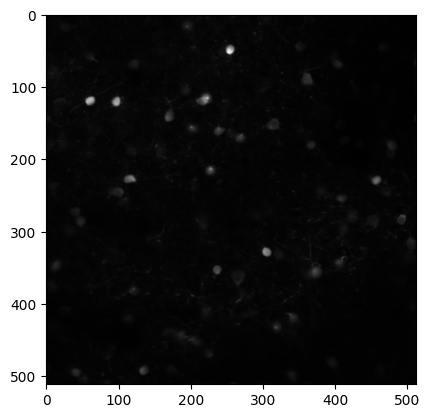

In [15]:
plt.imshow(avg, cmap='gray')

In [24]:
io.close()

## Check formatting 09/05/2024

### images

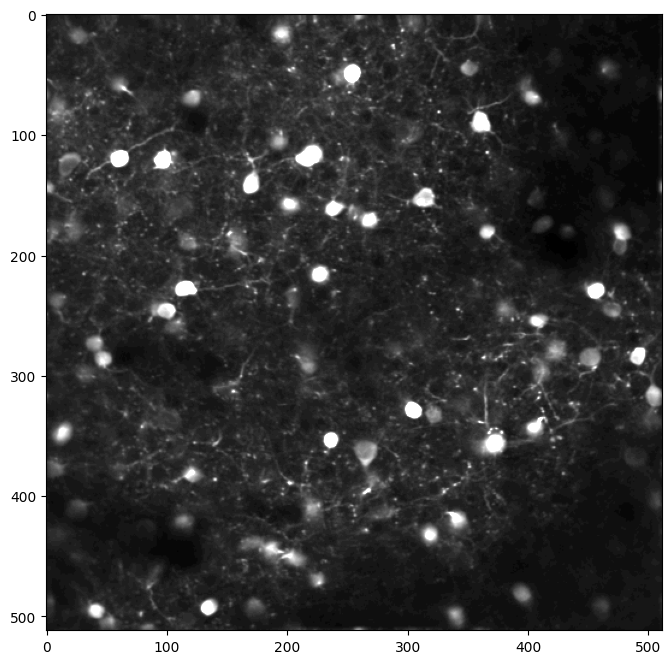

In [25]:
#img = nwb_open.processing[plane]['summary_images']['average_projection'].data[:]

# plot the average image, 10x10 vmax 99 percentile
plt.figure(figsize=(8,8))
plt.imshow(avg, cmap='gray', vmax=np.percentile(avg, 99))

## ROIS

In [20]:
rois_table 

,x,y,width,height,valid_roi,mask_image_plane,max_correction_up,max_correction_down,max_correction_left,max_correction_right,pixel_mask
id,,,,,,,,,,,
0,187,8,18,17,True,0,0,0,0,0,"[[7, 0, 1.0], [8, 0, 1.0], [9, 0, 1.0], [10, 0..."
1,19,10,18,16,True,0,0,0,0,0,"[[9, 0, 1.0], [3, 1, 1.0], [4, 1, 1.0], [5, 1,..."
2,460,38,16,16,True,0,0,0,0,0,"[[2, 0, 1.0], [3, 0, 1.0], [4, 0, 1.0], [5, 0,..."
3,278,39,17,17,True,0,0,0,0,0,"[[5, 0, 1.0], [6, 0, 1.0], [7, 0, 1.0], [8, 0,..."
4,248,42,14,15,True,0,0,0,0,0,"[[4, 0, 1.0], [5, 0, 1.0], [6, 0, 1.0], [7, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...
72,33,489,17,14,True,0,0,0,0,0,"[[4, 0, 1.0], [7, 0, 1.0], [8, 0, 1.0], [9, 0,..."
73,332,491,16,19,True,0,0,0,0,0,"[[6, 0, 1.0], [7, 0, 1.0], [8, 0, 1.0], [9, 0,..."
74,44,498,15,14,True,0,0,0,0,0,"[[7, 0, 1.0], [8, 0, 1.0], [6, 1, 1.0], [7, 1,..."


In [33]:
# one pixel mask
roi_pixel_mask = rois_table.pixel_mask.values[0]
roi_pixel_mask[:4]

array([(187, 15, 1.), (187, 16, 1.), (187, 17, 1.), (187, 18, 1.)],
      dtype=[('x', '<u4'), ('y', '<u4'), ('weight', '<f4')])

### plot pixel masks

<Axes: >

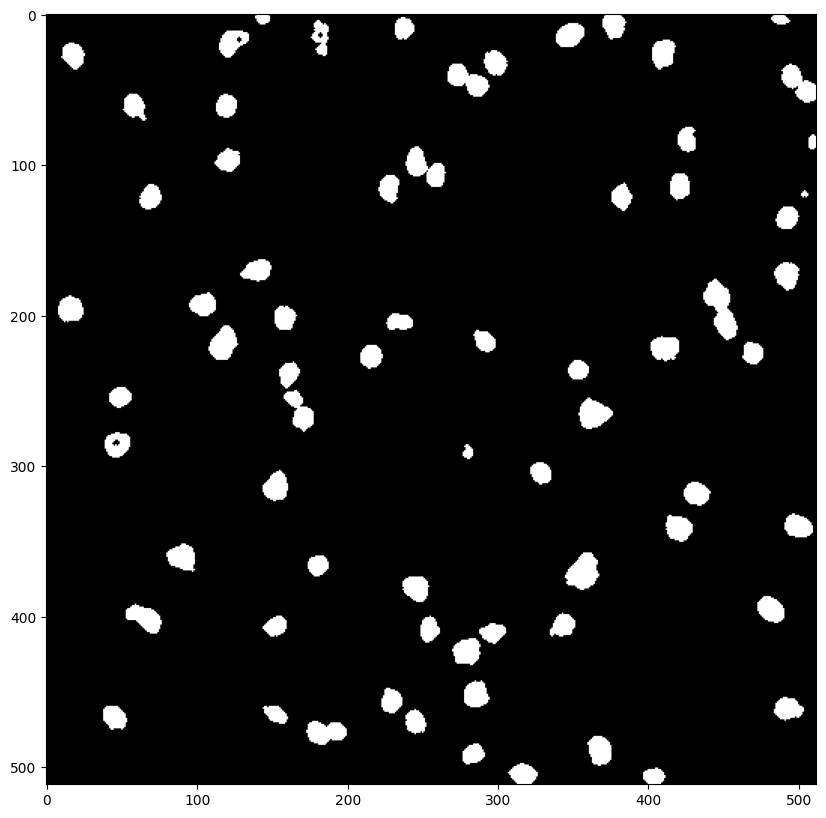

In [26]:
def plot_pixel_masks(pixel_masks: Union[list, pd.DataFrame], 
                     canvas_size: tuple = (512, 512),
                     ax = None) -> plt.Axes:
    """
    Plot pixel masks on a canvas.
    Example pixel mask:
    [(35,  3, 1.), 
     (35,  4, 1.), 
     (35,  5, 1.)]
    
    """
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))

    if isinstance(pixel_masks, pd.DataFrame):
        assert 'pixel_mask' in pixel_masks.columns
        pixel_masks = rois_table.pixel_mask.values

    canvas = np.zeros(canvas_size)
    for pixel_mask in pixel_masks:
        try:
            for x,y,z in pixel_mask:
                canvas[x,y] = z
        except:
            # warn that some pixels greater than canvas size
            print(f"Pixels found greather than canvas size {canvas_size}")
            continue

    ax.imshow(canvas, 
                cmap='gray', 
                interpolation=None)
    return ax

plot_pixel_masks(rois_table, canvas_size=(512, 512))

In [ ]:
def plot_pixel_masks(pixel_masks: Union[list, pd.DataFrame], 
                     canvas_size: tuple = (512, 512),
                     ax = None) -> plt.Axes:
    """
    Plot pixel masks on a canvas.
    Example pixel mask:
    [(35,  3, 1.), 
     (35,  4, 1.), 
     (35,  5, 1.)]
    
    """
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))

    if isinstance(pixel_masks, pd.DataFrame):
        assert 'pixel_mask' in pixel_masks.columns
        pixel_masks = rois_table.pixel_mask.values

    canvas = np.zeros(canvas_size)
    for pixel_mask in pixel_masks:
        try:
            for x,y,z in pixel_mask:
                canvas[y,x] = z
        except:
            # warn that some pixels greater than canvas size
            print(f"Pixels found greather than canvas size {canvas_size}")
            continue

    ax.imshow(canvas, 
                cmap='gray', 
                interpolation=None)
    return ax


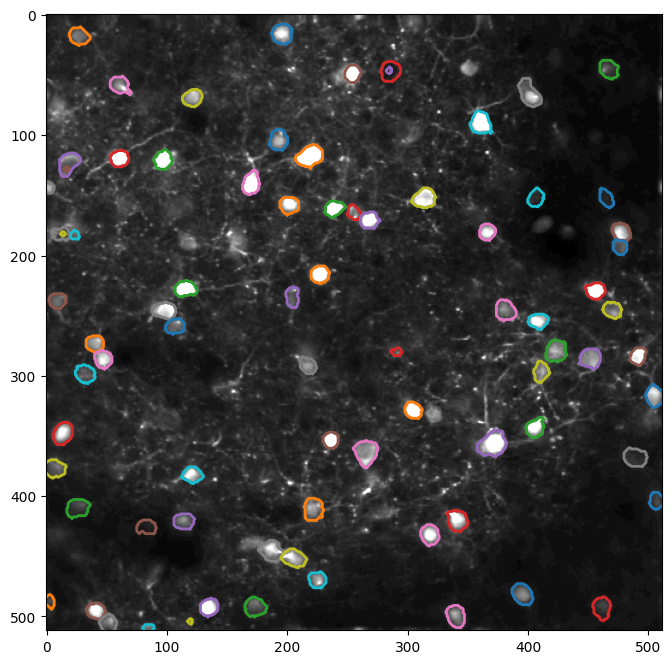

In [29]:
# plot contours for each roi
import skimage
img = avg
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, cmap='gray', vmax=np.percentile(img, 99))

for pixel_mask in rois_table.pixel_mask:
    try:
        mask = np.zeros((512, 512))
        for x,y,z in pixel_mask:
            mask[y,x] = z
        contours = skimage.measure.find_contours(mask, 0.8)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    except:
        print("Error")

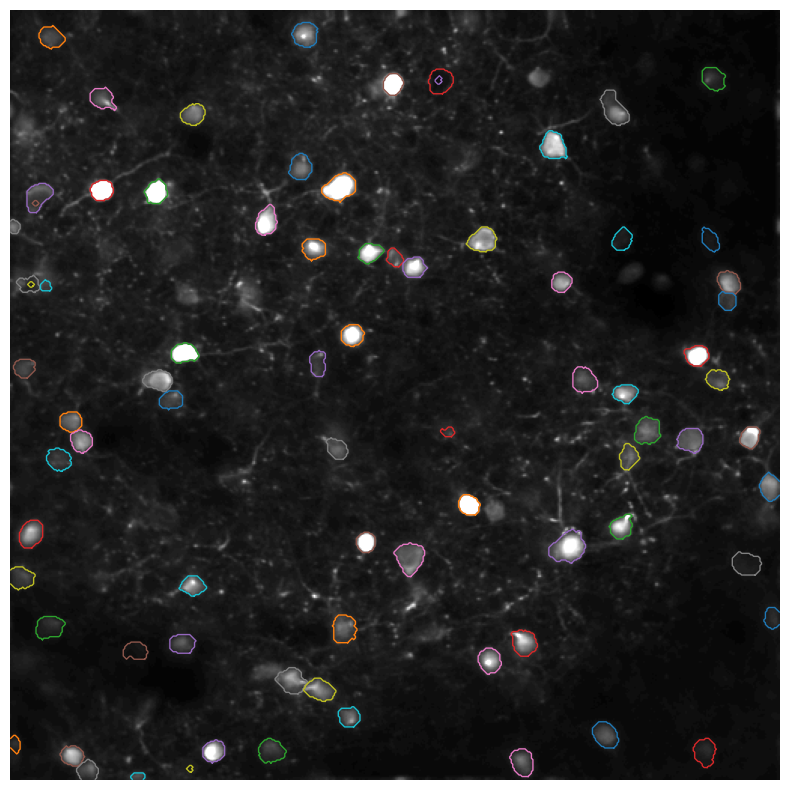

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure
from typing import Tuple

def plot_pixel_masks_contours(
    avg_image: np.ndarray,
    rois_table: pd.DataFrame,
    cmap: str = 'gray',
    vmax_percentile: int = 99.5,
    ax: plt.Axes = None
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot contours of ROI pixel masks on top of an average image.

    Parameters
    ----------
    avg_image : numpy.ndarray
        2D array representing the average image to use as background.
    rois_table : pandas.DataFrame
        DataFrame containing ROI information with a 'pixel_mask' column.
    figsize : tuple, optional
        Size of the figure (width, height) in inches. Default is (8, 8).
    cmap : str, optional
        Colormap to use for the background image. Default is 'gray'.
    vmax_percentile : int, optional
        Percentile to use for setting the maximum value in the background image. Default is 99.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure object.
    ax : matplotlib.axes.Axes
        The created axes object.

    Notes
    -----
    This function creates a plot with ROI contours overlaid on an average image.
    Each ROI's pixel mask is converted to a binary mask, and contours are drawn using skimage.

    Examples
    --------
    >>> fig, ax = plot_pixel_masks_contours(avg_image, rois_table)
    >>> plt.show()
    """
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(avg_image, cmap=cmap, vmax=np.percentile(avg_image, vmax_percentile))

    for pixel_mask in rois_table.pixel_mask:
        try:
            mask = np.zeros(avg_image.shape)
            for x, y, z in pixel_mask:
                mask[int(y), int(x)] = z
            contours = skimage.measure.find_contours(mask, 0.8)
            for contour in contours:
                ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
        except Exception as e:
            print(f"Error processing ROI: {e}")

    ax.axis('off')
    plt.tight_layout()
    return fig, ax

# Usage example:
fig, ax = plot_pixel_masks_contours(avg, rois_table)
plt.show()

In [18]:
#p

import matplotlib.pyplot as plt
from typing import List, Union

def plot_pixel_masks_return_errors(pixel_masks: Union[list, pd.DataFrame], 
                     canvas_size: tuple = (512, 512),
                     ax = None) -> plt.Axes:
    """
    Plot pixel masks on a canvas.
    Example pixel mask:
    [(35,  3, 1.), 
     (35,  4, 1.), 
     (35,  5, 1.)]
    
    """
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))

    if isinstance(pixel_masks, pd.DataFrame):
        assert 'pixel_mask' in pixel_masks.columns
        pixel_masks = rois_table.pixel_mask.values

    canvas = np.zeros(canvas_size)
    error_canvas = np.zeros((600, 600))
    for pixel_mask in pixel_masks:
        #print(pixel_mask)
        try:
            for x,y,z in pixel_mask:
                canvas[x,y] = z
        except:
            print()
            print("Error >512")
            print(pixel_mask)
            for x,y,z in pixel_mask:
                #if x > 511 or y > 511:
                #print(x,y,z)
                error_canvas[x,y] = z
            continue

    ax.imshow(canvas, 
               cmap='gray', 
               interpolation=None)
    return ax, error_canvas



ax, error_canvas = plot_pixel_masks_return_errors(rois_table)

# plot error
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(error_canvas, 
           cmap='viridis', 
           interpolation=None)




# plot dashed red line at 512 and 512
ax.plot([512, 512], [0, 512], 'r--')
ax.plot([0, 512], [512, 512], 'r--')


NameError: name 'rois_table' is not defined

In [17]:
# how many pixels are out of bounds
np.sum(error_canvas)

17.0

In [11]:
for _ in range(30):
    # randomly generate example starting points for region
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)

    # define an example 4 x 3 region of pixels of weight '1'
    pixel_mask = []
    for ix in range(x, x + 4):
        for iy in range(y, y + 3):
            pixel_mask.append((ix, iy, 1))

In [31]:
pixel_mask

[(85, 0, 1),
 (85, 1, 1),
 (85, 2, 1),
 (86, 0, 1),
 (86, 1, 1),
 (86, 2, 1),
 (87, 0, 1),
 (87, 1, 1),
 (87, 2, 1),
 (88, 0, 1),
 (88, 1, 1),
 (88, 2, 1)]

### read with

In [ ]:
# with NWBHDF5IO("ophys.nwb", "r") as io:
#     read_nwbfile = io.read()

#     roi_resp_series = read_nwbfile.processing["ophys"]["Fluorescence"][
#         "RoiResponseSeries"
#     ]